In [1]:
import acquire as a
import prepare as p
import wrangle as w
import explore as e
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler, RobustScaler

https://pen.do/support/difference-between-property-and-unit/

# Acquire

In [2]:
#Acquire data from SQL using my function

In [3]:
sql_query = '''
SELECT  parcelid, bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, 
taxvaluedollarcnt 
FROM properties_2017
JOIN predictions_2017 as pred USING (parcelid)
WHERE pred.transactiondate >= '2017-05-01' AND pred.transactiondate <= '2017-08-31'
AND (propertylandusetypeid > 259 AND propertylandusetypeid  < 265);
'''

In [4]:
df= a.get_data_from_sql('zillow',sql_query)

In [5]:
#check my df
df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
0,11721753,3.0,2.0,1316.0,205123.0
1,11289917,3.0,2.0,1458.0,136104.0
2,11705026,2.0,1.0,1421.0,35606.0
3,14269464,4.0,3.0,2541.0,880456.0
4,11446756,3.0,2.0,1491.0,107110.0


In [6]:
df.shape

(28185, 5)

**takeaways**
- My sql query filter:
   - single unit property .
   - transaction during  May-August, 2017

# Prepare

In [7]:
#use a function that gives us a quick report
w.miss_dup_values(df)

Your selected dataframe has 5 columns.
There are 2 columns that have missing values.
  
** There are 25 duplicate rows that represents 0.09% of total Values**


,Missing Values,% of Total Values
calculatedfinishedsquarefeet,68,0.2
taxvaluedollarcnt,1,0.0


In [8]:
# I'm going to drop duplicates

In [9]:
df = df.drop_duplicates()

In [10]:
#I'm going to drop the rows with missing values

In [11]:
df = df.dropna(how='any',axis=0)

In [12]:
w.miss_dup_values(df)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28093 entries, 0 to 28184
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28093 non-null  int64  
 1   bedroomcnt                    28093 non-null  float64
 2   bathroomcnt                   28093 non-null  float64
 3   calculatedfinishedsquarefeet  28093 non-null  float64
 4   taxvaluedollarcnt             28093 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.3 MB


In [14]:
# I'm going to change parcelid to string, it is a uniqure identifier for parcels lots
df['parcelid'] = df['parcelid'].astype('str')

In [15]:
df.dtypes

parcelid                         object
bedroomcnt                      float64
bathroomcnt                     float64
calculatedfinishedsquarefeet    float64
taxvaluedollarcnt               float64
dtype: object

In [16]:
df.rename(columns={'bedroomcnt': 'n_bedrooms', 
                    'bathroomcnt': 'n_bathrooms',
                    'calculatedfinishedsquarefeet':'sq_ft',
                     'taxvaluedollarcnt': 'usd_value'}, inplace=True)

In [17]:
#checking the uniques values for each column
columns = df.columns.tolist()
print( 'Columns')
print(" ")
cat_list = []
for col in columns:
    print(f'{col} --> {df[col].nunique()} unique values')
    if df[col].nunique() < 26:
        cat_list.append(col)
    print(" ")


Columns
 
parcelid --> 28093 unique values
 
n_bedrooms --> 13 unique values
 
n_bathrooms --> 20 unique values
 
sq_ft --> 4056 unique values
 
usd_value --> 22733 unique values
 


In [18]:
#checking  the variables that have few values
for l in cat_list:
    print(l)
    print(df[l].value_counts().sort_index())
    print("--------------------------- ")
    print(" ")

n_bedrooms
0.0        33
1.0       312
2.0      4347
3.0     12566
4.0      8286
5.0      2142
6.0       340
7.0        50
8.0         8
9.0         4
10.0        2
11.0        2
12.0        1
Name: n_bedrooms, dtype: int64
--------------------------- 
 
n_bathrooms
0.0        25
1.0      4903
1.5       451
2.0     11728
2.5      2208
3.0      5796
3.5       544
4.0      1198
4.5       384
5.0       443
5.5       111
6.0       176
6.5        27
7.0        52
7.5         9
8.0        29
8.5         1
9.0         5
10.0        1
11.0        2
Name: n_bathrooms, dtype: int64
--------------------------- 
 


** Takeaways**
- change parcelid to object type
- there are property whith 0 bedrooms and bathtooms. I will check this more

In [19]:
#explore n_bedrooms == 0 & n_bathroos == 0

In [20]:
df[(df.n_bedrooms == 0) & (df.n_bathrooms == 0)].count()

parcelid       19
n_bedrooms     19
n_bathrooms    19
sq_ft          19
usd_value      19
dtype: int64

In [21]:
df[(df.n_bedrooms == 0) & (df.n_bathrooms == 0)]

,parcelid,n_bedrooms,n_bathrooms,sq_ft,usd_value
8,11696784,0.0,0.0,1378.0,168828.0
254,11392193,0.0,0.0,2276.0,101792.0
339,11266326,0.0,0.0,400.0,49627.0
795,11938527,0.0,0.0,389.0,319396.0
1795,14507431,0.0,0.0,4184.0,1145602.0
3714,12153898,0.0,0.0,682.0,29361.0
4940,12554886,0.0,0.0,1064.0,226328.0
6238,11676853,0.0,0.0,660.0,746757.0
6611,12444585,0.0,0.0,738.0,84701.0
9497,11679076,0.0,0.0,1820.0,1034512.0


In [22]:
df.shape

(28093, 5)

**I decided to keep the properties with 0 bathrooms and bedrooms it represents a small percentage**

In [23]:
#checking calculatedfinishedsquarefeet
df.sq_ft.sort_values().head(20)

18570    240.0
2389     300.0
8853     326.0
14594    360.0
1362     360.0
13627    366.0
25817    380.0
20469    384.0
795      389.0
339      400.0
9775     400.0
20088    400.0
27669    440.0
26082    440.0
22493    440.0
12738    442.0
12016    444.0
19968    444.0
3932     448.0
27329    448.0
Name: sq_ft, dtype: float64

In [24]:
df[(df.sq_ft <400)]

,parcelid,n_bedrooms,n_bathrooms,sq_ft,usd_value
795,11938527,0.0,0.0,389.0,319396.0
1362,11417048,1.0,1.0,360.0,206054.0
2389,17258105,1.0,1.0,300.0,165579.0
8853,11361390,2.0,1.0,326.0,16084.0
13627,11283520,0.0,0.0,366.0,62030.0
14594,12074776,0.0,0.0,360.0,11089.0
18570,11915330,0.0,1.0,240.0,380000.0
20469,14276688,1.0,1.0,384.0,1486936.0
25817,13910907,1.0,1.0,380.0,87906.0


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28093 entries, 0 to 28184
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   parcelid     28093 non-null  object 
 1   n_bedrooms   28093 non-null  float64
 2   n_bathrooms  28093 non-null  float64
 3   sq_ft        28093 non-null  float64
 4   usd_value    28093 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.3+ MB


**takeaway**
- I decided to keep bathrooms and bedrooms = 0


In [26]:
#pd.cut(df.n_bedrooms,  [0, 2, 4, 12])


In [54]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
n_bedrooms,28093.0,3.314064,0.933615,0.0,3.0,3.0,4.0,12.0
n_bathrooms,28093.0,2.319920,1.013287,0.0,2.0,2.0,3.0,11.0
sq_ft,28093.0,1934.491475,994.195591,240.0,1279.0,1675.0,2326.0,17245.0
usd_value,28093.0,533148.215214,703712.863914,1000.0,198427.0,382000.0,631675.0,23858374.0


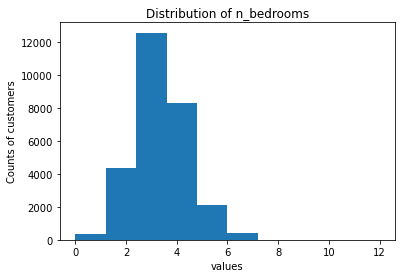

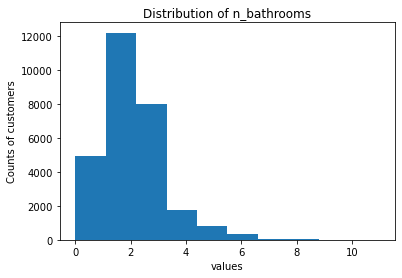

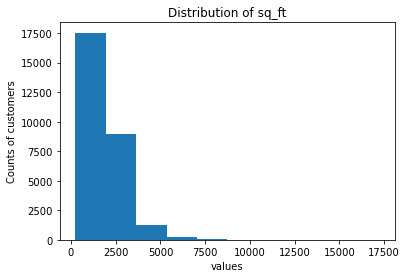

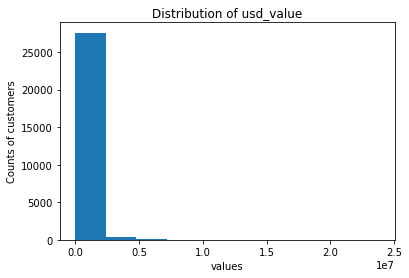

In [27]:
p.distribution(df)

because all my features are continous i decided to boxplot

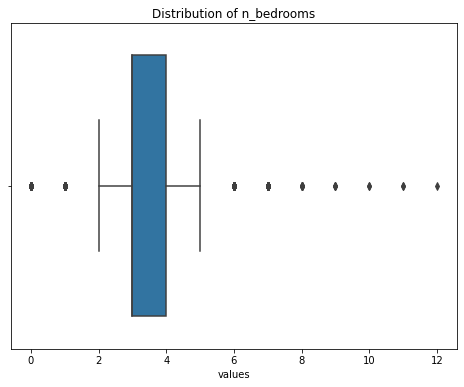

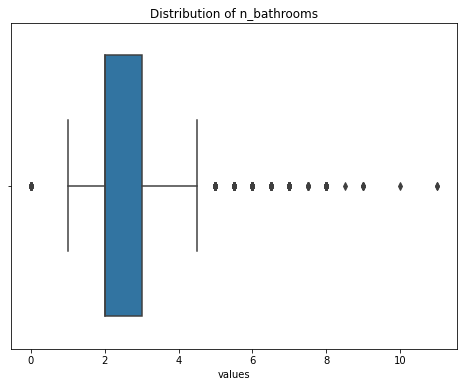

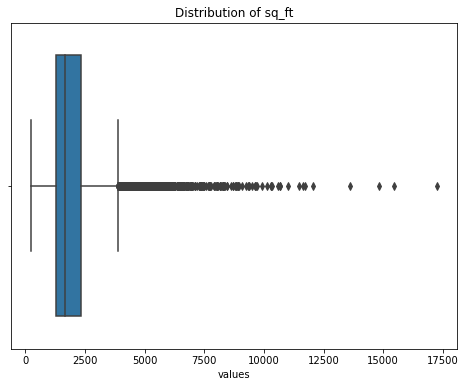

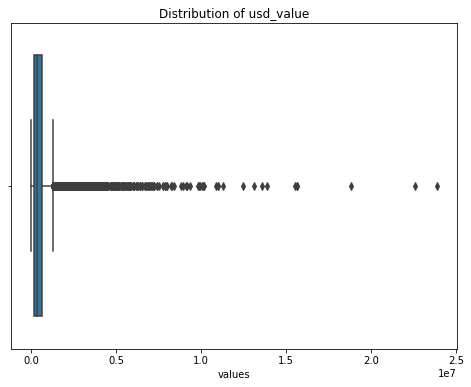

In [35]:
p.distribution_boxplot(df)

**Takeaways** 
-  bathrooms , bedrooms, sq_dt and usd_valure are continous.
- target is  usd_value


### split train, validate, test

In [28]:
train, validate, test = p.split_data(df)

train -> (15731, 5)
validate -> (6743, 5)
test -> (5619, 5)


In [29]:
X_train, y_train, X_validate, y_validate, X_test, y_test = p.split_Xy(train,validate,test, 'usd_value')

X_train -> (15731, 4)               y_train->(15731,)
X_validate -> (6743, 4)         y_validate->(6743,) 
X_test -> (5619, 4)                  y_test>(5619,)


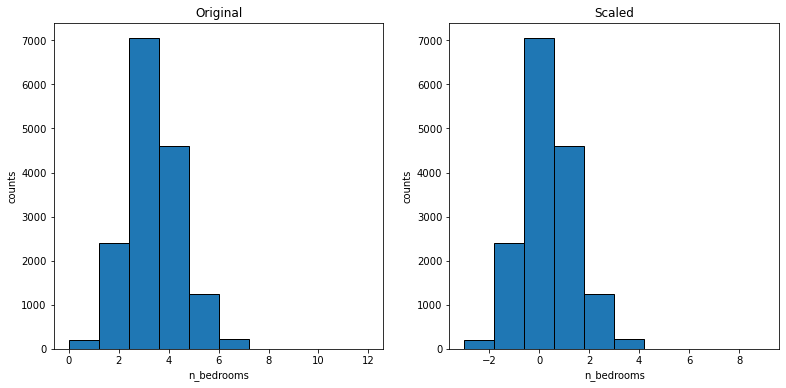

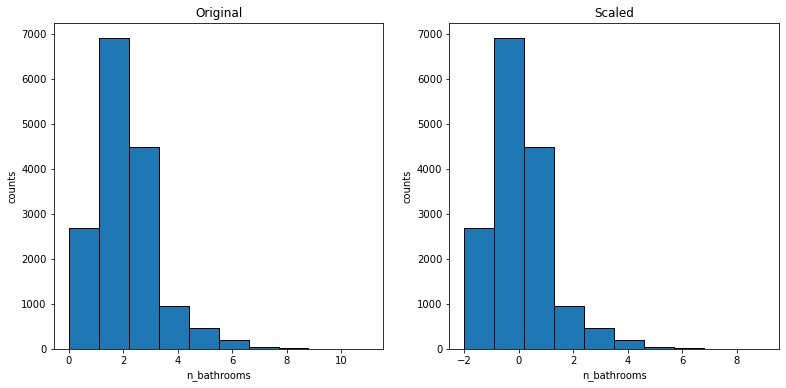

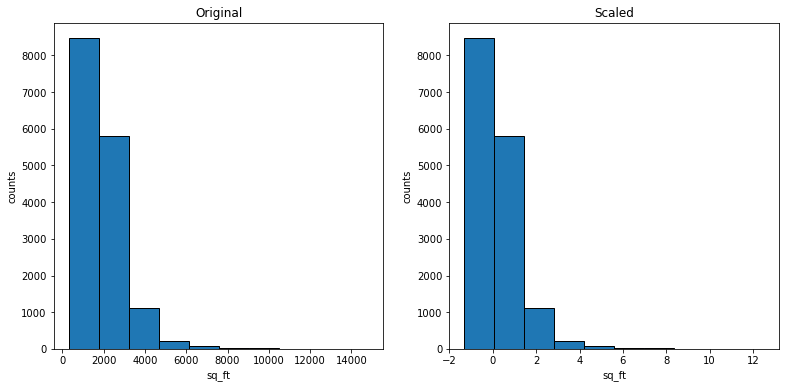

In [59]:
#Scale our data
X_train_scaled, X_validate_scaled, X_test_scaled = p.scaled_df(X_train, X_validate, X_test, RobustScaler())

**takeaways**
- I use Robust Scaler that uses parameters that are more robust to outliers,  because  bathrooms , bedrooms, and sq_dt have outliers.

# Expolore


In [ ]:
#  I want to explore with my target

<AxesSubplot:>

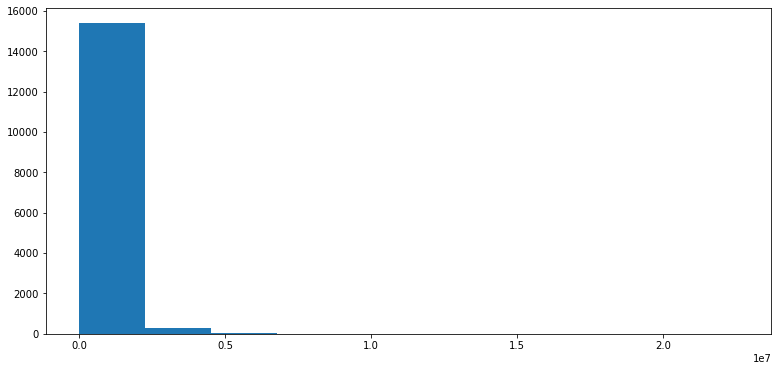

In [46]:
plt.figure(figsize=(13, 6))
train['usd_value'].hist(grid=False,)


<AxesSubplot:xlabel='usd_value'>

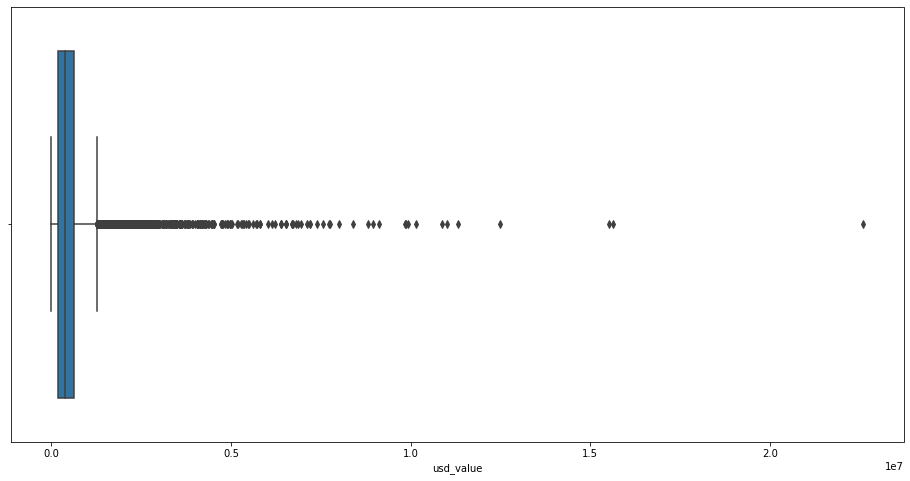

In [50]:
plt.figure(figsize=(16, 8))
sns.boxplot(train['usd_value'])

<Figure size 1152x576 with 0 Axes>

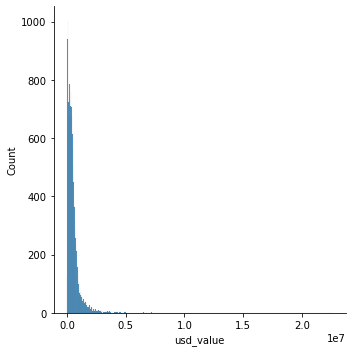

In [52]:
plt.figure(figsize=(16, 8))
sns.displot( train['usd_value'])


In [ ]:
# I creating a new df 

In [60]:
train_scaled = pd.concat([X_train_scaled, pd.DataFrame( {'usd_value': y_train}) ], axis= 1 )

In [61]:
train_scaled.head()

,n_bedrooms,n_bathrooms,sq_ft,usd_value
20267,0.0,0.0,0.021884,232000.0
21840,1.0,1.0,0.512845,93881.0
10960,0.0,0.0,0.193149,143891.0
25650,0.0,1.0,0.469077,744630.0
11243,1.0,0.0,1.006660,496457.0


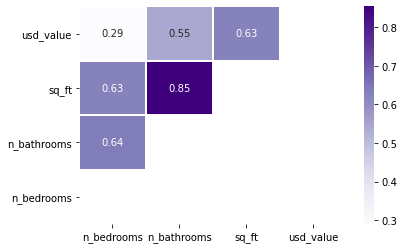

In [64]:
e.heatmap(train_scaled)

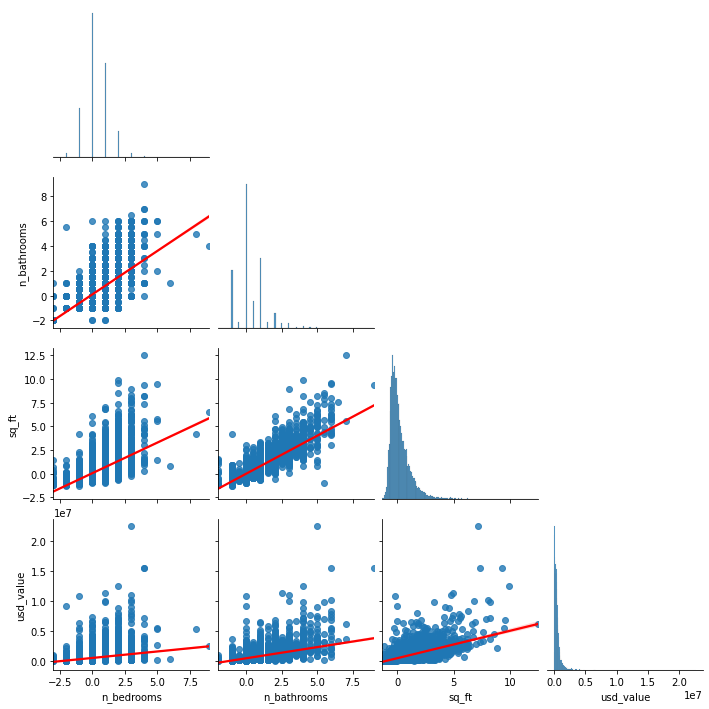

In [62]:
sns.pairplot(train_scaled, kind="reg", plot_kws={'line_kws':{'color':'red'}}, corner=True)

**Takeaways**
- sq_ft has more correlation with our target
- sq_ft has higher correlation n_bathrooms